# Assignment 5: Deep Image Prior

**Due Date:** Feb 10, 2019.

**Submission:** In pairs, [here]().

**Student 1**
</br>**Name:** Shahaf Wagner
</br>**Email:** shahaf.wagner@weizmann.ac.il


**Student 2**
</br>**Name:** Omri Kramer
</br>**Email:** omri.kramer@weizmann.ac.il

## Introduction

In a recent CVPR paper [Deep Image Prior](http://openaccess.thecvf.com/content_cvpr_2018/papers/Ulyanov_Deep_Image_Prior_CVPR_2018_paper.pdf) it was shown by Ulyanov et al. that deep neural nets have an inductive bias toward _natural images_: that is, if using a deep net architecture to generate an image it is _easier_ for the net to produce naturally looking images rather than noisy or blurry ones. Based on this observation, they proposed to use deep neural nets as a prior for image enhancement tasks.

In this exercise we will follow their lead and try different deep architectures as _prior_ for the task of image denoising. In order to denoise an image using the _Deep Image Prior_ framework one needs a deep net that **takes random noise** and **generates the noisy image** from it (we assume we do not have the clean image, we will use it only for measuring performance). Because of the inductive bias of deep nets toward natural images we expect a clean version of the image to emerge earlier in the process before the net overfits and produces the noise as well.

The exercise has three parts, with three main basic architectures:
* 1D-Generator (generating from 1D noise)
* 2D-Generator (generating from 2D noise)
* 2D-Generator with skip-connections

Throughout the exercise we encourage you to try various design choices so you can get the "feel" of working and experimenting with deep learning. We don't aim here for a specific solution, but rather are interested in the process (but we do hope you get appealing results in the end!). You are given a set of qestions for each part, please answer them but also feel free to discuss other insights you have from your experiments. 

## Setup
FIrst, we'd like to use the free GPU provided by Google Colab. This will accelerate the training by an order of magnitude.
1. In the menu, select: **Runtime -> Change runtime type**.
2. Choose "GPU" under **Hardware accelerator**.

Next, we'll need to install some python dependencies, and to download the dataset. You may need to repeat this process when the runtime is started.
1. Run the cell **Install requirements**.
2. Run the second cell in **Download dataset**.
3. Restart the runtime, either by typing **"`Ctrl+M .`"**, or by using the menus: **Runtime -> Restrart runtime...** .


In [0]:
#@title Install requirements
#@markdown Please run this cell to install python dependencies.
#@markdown When finished, type **`Ctrl+M .`** to restart the runtime. Alternatively, use the menus **Runtime -> Restart Runtime...**
#@markdown This should fix the following error:<br/>`AttributeError: module 'PIL.Image' has no attribute 'register_extensions'`

# Install pytorch=1.0.0
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
if accelerator.startswith('cu9'):
  accelerator = 'cu90'  
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision


# Install pillow=5.4.1
!pip install -U -q "pillow~=5.4.1"


# Install livelossplot
!pip install -U -q "livelossplot~=0.3.0"


# should fix a problem with pillow
%reload_ext autoreload
%autoreload


In [0]:
#@title Download dataset
#@markdown Please run this cell to download the datasets.

# download images
!wget -q https://wis-intro-vision-2019.wikidot.com/local--files/assignments/ex5-data.tar.gz
!tar -zxf ex5-data.tar.gz && rm -f ex5-data.tar.gz

In [0]:
#@title Download dataset-v2
#@markdown Please run this cell to download dataset-v2 (which conforms with PSNR of +29dB).
 
# download images
!wget -q https://wis-intro-vision-2019.wikidot.com/local--files/assignments/ex5-data-v2.tar.gz
!tar -zxf ex5-data-v2.tar.gz && rm -f ex5-data-v2.tar.gz


## General imports

If you encounter an error in this step, please follow the setup instructions above.

In [0]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

## Utility Methods

You may want to use the provided utility functions, instead of implementing them yourselves.

### I/O

In [0]:
def gdrive_mount():
  if os.path.isdir('/gdrive'):
    return True

  import google.colab
  google.colab.drive.mount('/gdrive')  


def gdrive_path(path):
  return os.path.join('/gdrive/My Drive', path)

In [0]:
import tempfile

import PIL

import IPython.display

# Low-Level Utility Methods

def _img_to_float32(image, bounds=(0, 1)):
  """Receives an `image` and range `bounds`, 
     normalizes it and converts it to `float32`. 

  Arguments:
    image (np.ndarray): the image
    bounds (Tuple[float, float], optional): expected minimum and maximum values 
                                            of image pixels

  Returns:
    np.ndarray: the converted image, with `dtype=np.float32`.

  """
  minval, maxval = bounds
  image = np.asarray(image, dtype=np.float32) / 255.0
  image = np.clip((maxval - minval) * image + minval, minval, maxval)
  return image


def _img_to_uint8(image, bounds=(0, 1)):
  """Receives an `image` and range `bounds`, 
     noramlizes it and converts it to `uint8`.

  Arguments:
    image (np.ndarray): the image
    bounds (Tuple[float, float], optional): expected minimum and maximum values 
                                            of image pixels

  Returns:
    np.ndarray: the converted image, with `dtype=np.uint8`.
    
  """
  if image.dtype != np.uint8:
    minval, maxval = bounds
    image = (image.astype(np.float32) - minval) / (maxval - minval)
    image = (image * 255.0).round().clip(0, 255).astype(np.uint8)
  return image


def _check_path(path):
  """Checks whether a path exists. 
  If not, the required missing directories are created"""
  path = os.path.abspath(path)
  if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
  return path


# High-Level Utility Methods

def imread(path, size=(256, 256), bounds=(0, 1)):
  """Reads an image, changes its size to match `size` (may crop and lose data),
     and converts it to float.
  
  Arguments:
    path (str): path to image
    size (Tuple[int, int], optional): desired image size
    bounds (Tuple[float, float], optional): expected minimum and maximum values 
                                            of image pixels
  
  Returns:
    image (np.ndarray): the image, where it values are in the given `bounds`.
  
  """
  image = PIL.Image.open(path).convert(mode='RGB')
  if size is not None:
    scale_factor = max([float(size[dim]) / float(image.size[dim]) for dim in range(2)])
    new_size = [int(scale_factor * sz) for sz in image.size]
    image = image.resize(new_size, PIL.Image.LANCZOS)
    left, top = [(image.size[dim] - size[dim]) // 2 for dim in range(2)] 
    image = image.crop((left, top, left + size[0], top + size[1]))
  image = _img_to_float32(image, bounds)
  return image


def imwrite(path, image, bounds=(0, 1), **kwargs):  
  """Normalize `image` and save it to `path`.

  Arguments:
    path (str): saving location
    image (np.ndarray): the image
    bounds (Tuple[float, float], optional): expected minimum and maximum values 
                                            of image pixels
  """  
  image = _img_to_uint8(image, bounds)
  path = _check_path(path)
  image = PIL.Image.fromarray(image)
  image.save(path, **kwargs)


def imshow(image, path=None, **kwargs):
  """Normalize `image`, save it, and show it.

  Arguments:
    path (str): saving location (if None, image is save to temporary location)
    image (np.ndarray): the image
  
  """
  fd = None
  if path is None:
    fd, path = tempfile.mkstemp(suffix='.png')
  
  imwrite(path, image, **kwargs)  
  output = IPython.display.Image(path)
  
  if fd is not None:
    os.close(fd)
  
  display(output)


# colab version
try:
  import google.colab.widgets
  
  def imshow_tabs(noisy, result, clean=None, paths=None, **kwargs):
    """Normalizes input images (`noisy`, `result`, and possible `clean`)
    and shows them in tabs.

    Arguments:
      noisy (np.ndarray): noisy image to show.
      result (np.ndarray): cleaned image to show.
      clean (np.ndarray, optional): ground truth clean image to show.
      paths (List[str]], optional): list of locations to save the images to.
    
    """
    images = [noisy, result]
    titles = ['noisy', 'result']
    if clean is not None:
      images.append(clean)
      titles.append('clean')
    if paths is None:
      paths = [None] * len(titles)
    assert len(paths) == len(titles)
    
    tab = google.colab.widgets.TabBar(titles)
    
    for title, path, image in zip(titles, paths, images):
      with tab.output_to(title):
        imshow(image, path=path, **kwargs)


# jupyter version
except ImportError:
  import ipywidgets
  
  def imshow_tabs(noisy, result, clean=None, paths=None, **kwargs):
    """Normalizes input images (`noisy`, `result`, and possible `clean`)
    and shows them in tabs.

    Arguments:
      noisy (np.ndarray): noisy image to show.
      result (np.ndarray): cleaned image to show.
      clean (np.ndarray, optional): ground truth clean image to show.
      paths (List[str]], optional): list of locations to save the images to.
    
    """
    images = [noisy, result]
    titles = ['noisy', 'result']
    if clean is not None:
      images.append(clean)
      titles.append('clean')
    if paths is None:
      paths = [None] * len(titles)
    assert len(paths) == len(titles)

    tab = ipywidgets.Tab([ipywidgets.Output() for _ in titles])
    
    for i, (title, path, image) in enumerate(zip(titles, paths, images)):
      tab.set_title(i, title)
      with tab.children[i]:
        imshow(image, path=path, **kwargs)
    
    display(tab)

### Evaluation

In [0]:
def root_mean_square_error(a, b):
  """Computes the RMSE between two images, or between two batches of images.
  
  Arguments:
    a (np.ndarray): the first image (or batch of images, stacked along axis 0)
    b (np.ndarray): the second image (or batch of images, stacked along axis 0)
  
  Returns:
    rmse (float / np.ndarray): if `a` has 2 or 3 dimensions, returns the
                               RMSE between `a` and `b`.
                               if `a` has 4 dimensions, returns a list of
                               RMSE between corresponding images in `a`
                               and `b`. 
  """
  assert a.ndim in {2, 3, 4}, '`a` should have 2/3/4 dimensions'
  assert a.shape == b.shape, '`a` and `b` should have the same shape'
  
  # batch of images
  if a.ndim == 4:  
    mse = np.mean((a - b)**2, axis=(1, 2, 3))
  
  # single image
  else:            
    mse = np.mean((a - b)**2)
  
  return np.sqrt(mse)
    

def peak_signal_noise_ratio(a, b, bounds=(0, 1)):
  """Computes the PSNR between two images, or between two batches of images.
  
  Arguments:
    a (np.ndarray): the first image (or batch of images, stacked along axis 0)
    b (np.ndarray): the second image (or batch of images, stacked along axis 0)
    bounds (Tuple[float, float]): the valid bounds of `a` and `b`.
 
  Returns:
    psnr (float / np.ndarray): if `a` has 2 or 3 dimensions, returns the
                               PSNR between `a` and `b`.
                               if `a` has 4 dimensions, returns list of
                               PSNR between corresponding images in `a`
                               and `b`.
  """

  assert a.ndim in {2, 3, 4}, '`a` should have 2/3/4 dimensions'
  assert a.shape == b.shape, '`a` and `b` should have the same shape'
  
  minval, maxval = bounds
  rmse = root_mean_square_error(a, b)
  return 20 * np.log10(maxval - minval) - 20 * np.log10(rmse)

### Datasets

In [0]:
def list_dataset(dataset_dir='dataset'):
  """Lists the images in a given dataset.
  
  Arguments:
    dataset_dir (str): where the dataset is.
  
  Returns:
    dataset (List[str]): list of paths to images in the dataset.
  """
  return sorted([os.path.join(dataset_dir, fname) for fname in os.listdir(dataset_dir)])

### Training

In [0]:
def add_noise(images, scale=0.1, bounds=(0, 1)):
  """Adds i.i.d. Gaussian noise to all the pixels of an image
  
  Arguments:
    images (np.ndarray): an image (or batch of images)
    sigme (float): scale for noise
    bounds (Tuple[float, float], optional): desired minimum and maximum values 
                                            of image pixels
                                            
  Returns: 
    np.ndarray: noisy images
    
  """
  minval, maxval = bounds
  noise = np.random.uniform(-scale, scale, size=images.shape)
  return np.clip(images + noise, minval, maxval)

In [0]:
import livelossplot
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid', 'seaborn-notebook'])

class Tracker(object):
  def __init__(self, fig_path=None):
    """Creates a tracker, that keeps track of training.
    
    You should probably create a tracker when creating the network, because they
    are usually coupled.

    Arguments:
      fig_path (str, optional): where to save an image of the tracker's plots.

    """
    self._plot = livelossplot.PlotLosses(
      plot_extrema=False,
      fig_path=fig_path,
      metric2title={'loss': 'Loss', 'rmse': 'RMSE', 'psnr': 'PSNR'}
    )
  
  def update(self, logs):
    """Update the tracker's data.
    
    Arguments:
      logs (dict): a dictionary with data for the tracker. Valid keys are
                   'loss', 'rmse', 'pnsr' and 'val_*' (for the mentioned keys).
                   'val_*' key means value on validation data.
                   the value corresponding to the key should be a single value,
                   not an array.
    
    """
    self._plot.update(logs)
  
  def draw(self):
    """Refresh the tracker's plot."""
    self._plot.draw()

In [0]:
class DeepImagePriorTrainer(object):
  def __init__(self, noise_input, noisy_image, clean_image=None, device=None):
    """Trainer for Deep Image Prior, on a given pre-set example.
    
    Arguments:
      noise_input (np.ndarray): vector of the noise to use as the network's input.
      noisy_image (np.ndarray): the noisy image the network tries to learn.
      clean_image (np.ndarray, optional): the clean image (ground truth).
                                          SHOULD BE USED FOR VALIDATION ONLY!!!
      device (str, optional): where to run. If None, chooses device automatically.
                              Usually better to keep this unchanged.
    
    """
    if device is None:
      device = "cuda:0" if torch.cuda.is_available() else "cpu"
    self.device = device
    
    if noise_input.ndim == 3:
      noise_input = np.transpose(noise_input, (2, 0, 1))
    self.noise = noise_input[None, ...]
    self.noise_t = torch.as_tensor(self.noise, dtype=torch.float32, device=self.device)

    self.noisy = np.transpose(noisy_image, (2, 0, 1))[None, ...]
    self.noisy_t = torch.as_tensor(self.noisy, dtype=torch.float32, device=self.device)
    
    if clean_image is not None:
      self.clean = np.transpose(clean_image, (2, 0, 1))[None, ...]
      self.clean_t = torch.as_tensor(self.clean, dtype=torch.float32, device=self.device)
    else:
      self.clean = None
      self.clean_t = None

  def train(self, net, optimizer, criterion, epochs, output_rate=50, tracker=None):
    """Trains a Deep Image Prior network on the pre-set example (input noise and noisy image).
    
    Arguments:
      net (torch.nn.Module): your network. receives the noise, and should return the image.
      optimizer (torch.optim.Optimizer): optimizer (make sure it's optimizing net's parameters).
      criterion: loss function.
      epochs (int): number of training iterations.
      output_rate (int): how frequently (number of epochs) should the tracker's plot be refreshed.
      tracker (Tracker, optional): tracker of the training.
      
    """
    net = net.to(self.device)
    net.train()
    
    for step in range(epochs):
      optimizer.zero_grad()
      cleaned_t = net(self.noise_t)
      loss_t = criterion(cleaned_t, self.noisy_t)
      loss_t.backward()
      optimizer.step()
      
      logs = {}
      cleaned = cleaned_t.cpu().detach().numpy()

      # report learning on provided (noisy) image
      loss = loss_t.item()
      logs['rmse'] = root_mean_square_error(cleaned, self.noisy)[0]
      logs['psnr'] = peak_signal_noise_ratio(cleaned, self.noisy)[0]
      logs['loss'] = loss

      # report learning on ground-truth (clean) image
      if self.clean is not None:
        with torch.no_grad():
          val_loss_t = criterion(cleaned_t, self.clean_t)
        val_loss = val_loss_t.item()
        logs['val_rmse'] = root_mean_square_error(cleaned, self.clean)[0]
        logs['val_psnr'] = peak_signal_noise_ratio(cleaned, self.clean)[0]
        logs['val_loss'] = val_loss
      
      if tracker is not None:
        tracker.update(logs)
      
      if step % output_rate == 0:
        if tracker is not None:
          tracker.draw()
        else:
          print(logs)  # print logs
        
    if tracker is not None:
      tracker.draw()
  
  def eval(self, net):
    """Predicts the image by feeding `net` with the pre-set noise.
    
    Arguments:
      net (torch.nn.Module): network to feed with input noise, and take its prediction as image.
      
    Returns:
      image (np.ndarray): the predicted imaged.
    """
    net = net.to(self.device)
    net.eval()
    
    cleaned_t = net(self.noise_t)
    cleaned = cleaned_t.cpu().detach().numpy()
    return np.transpose(cleaned[0, ...], (1, 2, 0))

In [0]:
def example_main_loop(net, opt_class, opt_kwargs, criterion, noise_size, image_path, sigma, epochs, tracker=None, output_rate=50):
  optimizer = opt_class(net.parameters(), **opt_kwargs)
  noise_input = np.random.normal(size=noise_size).astype(np.float32)
  clean_image = imread(image_path, size=(256, 256))
  noisy_image = add_noise(clean_image, sigma)
  dip = DeepImagePriorTrainer(noise_input, noisy_image, clean_image)
  dip.train(net, optimizer, criterion, epochs=epochs, tracker=tracker, output_rate=output_rate)
  result_image = dip.eval(net)
  if tracker:
    imshow_tabs(noisy_image, result_image, clean_image)
  return result_image, peak_signal_noise_ratio(result_image, clean_image)

## Deep Image Prior

In this exercise, you'll test several architectures for _Deep Image Prior_. For **each** architecture, answer the following questions (in the report):
1. Does the "inductive bias" assumption hold? Do we see a clean image emerge before noise is being reconstructed? Is the net "rich" enough to overfit the noise?
2. What is the effect of each design choice?
3. Report average PSNR on all images.
4. How many trainable parameters are in the model? How many operations (Mult/Add)?

Support your claims by examples (of cleaned images), plots, etc.

### 1. 1D-Generator

Construct a "generating" net that expects as input a 1D random noise vector, passes it through a fully connected layer to arranges it in a 2D feature space. Add "upsampling" convolutional layers to produce the target image.

#### Design Choices
1. "width" of the different layers (number of filters)
2. Number of different layers: how many "upsamples", by what scale factor each time
3. "Upsample" method: transposed convolution vs. interp + conv (see [here](https://distill.pub/2016/deconv-checkerboard/))
4. How to init weights: uniform/random/zero?
5. What loss to use? L1/L2/CE?
6. Regularization?
7. Solver: SGD (with and without momentum) / ADAM
8. Learning rates: try different values `1e-5`, `1e-3`, `1e-1`, `1e1`. \\
See effect of learning rate on optimization progress: slow progress vs divergence.

In [0]:
class Generator1D(nn.Module):
  def __init__(self):
    super(Generator1D, self).__init__()
    
    self.fc = nn.Linear(in_features=256*3 , out_features=16*16*32)
    self.conv1 = nn.Conv2d(in_channels=32,
                          out_channels=32,
                          kernel_size=9,
                          padding=4)
    
    self.bn1 = nn.BatchNorm2d(32)
    
    self.conv2 = nn.Conv2d(in_channels=32,
                          out_channels=32,
                          kernel_size=7,
                          padding=3)
    
    self.bn2 = nn.BatchNorm2d(32)
    
    self.conv3 = nn.Conv2d(in_channels=32,
                          out_channels=32,
                          kernel_size=5,
                          padding=2)
    
    self.bn3 = nn.BatchNorm2d(32)
    
    self.conv4 = nn.Conv2d(in_channels=32,
                          out_channels=32,
                          kernel_size=3,
                          padding=1)
    
    self.bn4 = nn.BatchNorm2d(32)

    self.conv5 = nn.Conv2d(in_channels=32,
                      out_channels=3,
                      kernel_size=3,
                      padding=1)

   
  def forward(self, x):
    x = self.fc(x)
    x = F.rrelu(x)
    x = x.reshape(1, 32, 16, 16)
    x = F.interpolate(x, scale_factor=2)
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.rrelu(x)
    x = F.interpolate(x, scale_factor=2)
    x = self.conv2(x)
    x = self.bn2(x)
    x = F.rrelu(x)
    x = F.interpolate(x, scale_factor=2)
    x = self.conv3(x)
    x = self.bn3(x)
    x = F.rrelu(x)
    x = F.interpolate(x, scale_factor=2)
    x = F.rrelu(self.bn4(self.conv4(x)))
    x = self.conv5(x)
    return x

### 2. 2D-Generator

Construct a "U-net": start with 2D noise the same size as the input image (but maybe more/less channels). Add some conv + stride/pooling layers to reduce spatial dimensions and creating an "information bottleneck", then use "upsampling" blocks to recover the original spatial resolution.

#### Design Choices
1. "width" of the different layers
2. Number of different layers: how many "upsamples", by what scale factor each time
3. "Upsample" method: transposed convolution vs. interp + conv (see [here](https://distill.pub/2016/deconv-checkerboard/))
4. How to init weights: uniform/random/zero?
5.Use the loss function that worked best for you in the previous part
6. Regularization?


In [0]:
class Generator2D(nn.Module):
  def __init__(self):
    super(Generator2D, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=32,
                          out_channels=32,
                          kernel_size=5,
                          padding=2,
                          stride=2)
    self.bn1 = nn.BatchNorm2d(32)
    
    self.conv2 = nn.Conv2d(in_channels=32,
                          out_channels=64,
                          kernel_size=3,
                          padding=1,
                          stride=2)
    self.bn2 = nn.BatchNorm2d(64)
    
    self.conv3 = nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=3,
                          padding=1,
                          stride=2)
    self.bn3 = nn.BatchNorm2d(64)
    
    self.conv4 = nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=3,
                          padding=1,
                          stride=2)
    self.bn4 = nn.BatchNorm2d(128)
    
    self.conv5 = nn.Conv2d(in_channels=128,
                          out_channels=64,
                          kernel_size=3,
                          padding=1)
    self.bn5 = nn.BatchNorm2d(64)
   
    self.conv6 = nn.Conv2d(in_channels=64,
                          out_channels=32,
                          kernel_size=3,
                          padding=1)
    self.bn6 = nn.BatchNorm2d(32)
    
    self.conv7 = nn.Conv2d(in_channels=32,
                          out_channels=16,
                          kernel_size=3,
                          padding=1)
    self.bn7 = nn.BatchNorm2d(16)
    
    self.conv8 = nn.Conv2d(in_channels=16,
                          out_channels=8,
                          kernel_size=3,
                          padding=1)
    self.bn8 = nn.BatchNorm2d(8)
    
    self.conv9 = nn.Conv2d(in_channels=8,
                          out_channels=3,
                          kernel_size=5,
                          padding=2)
    
    self.upsample_mode = 'bilinear'
    self.activation = nn.LeakyReLU()
    
  def forward(self, x):
    # ENTER YOUR SOLUTION HERE
    x = x.view(1, 32, 256, 256)
    x = self.activation(self.bn1(self.conv1(x)))
    x = self.activation(self.bn2(self.conv2(x)))
    x = self.activation(self.bn3(self.conv3(x)))
    x = self.activation(self.bn4(self.conv4(x)))
    
    x = F.interpolate(x, scale_factor=2, mode=self.upsample_mode)
    x = self.activation(self.bn5(self.conv5(x)))
    
    x = F.interpolate(x, scale_factor=2, mode=self.upsample_mode)
    x = self.activation(self.bn6(self.conv6(x)))
    
    x = F.interpolate(x, scale_factor=2, mode=self.upsample_mode)
    x = self.activation(self.bn7(self.conv7(x)))
    
    x = F.interpolate(x, scale_factor=2, mode=self.upsample_mode)
    x = self.activation(self.bn8(self.conv8(x)))
    
    x = self.conv9(x)
    return x

### 3. 2D-Generator with skip-connections

Use the same "U-net" architecture from previous part, but now add "skip connections" connecting feature maps of same spatial resolution from the "downscale" part to the "upscale" part.

#### Design Choices
1. "width" of the different layers, and specifically, the "width" of the skip connections.
2. How to propagate the information passed through "skip connections": do we add it (like residual links), or concat it (like "densenet")?

In [0]:
class ConvNormBlock(nn.Module):
  '''A block consisting of Conv2d - BatchNorm - Activation layers.'''
  def __init__(self, activation, in_ch, out_ch, kernel_size=3, padding=1,
               stride=1):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_ch,
                          out_channels=out_ch,
                          kernel_size=kernel_size,
                          padding=padding,
                          stride=stride
                         )
    self.bn = nn.BatchNorm2d(out_ch)
    self.activation = activation
    
    
  def forward(self, x):
    x = self.activation(self.bn(self.conv(x)))
    return x
    
    
class UpSampleConv(nn.Module):
  '''A block consisting of interpolation(2 scale) - Conv2d - Activation layer'''
  def __init__(self, mode, activation, in_ch, out_ch, kernel_size=3, padding=1,
               stride=1):
    super().__init__()
    self.conv_norm = ConvNormBlock(activation, in_ch, out_ch,
                                   kernel_size=kernel_size, padding=padding,
                                   stride=stride
                                  )
    self.mode = mode
    
  def forward(self, x, prev_x):
    x = F.interpolate(x, scale_factor=2, mode=self.mode)
    x = torch.cat((x, prev_x), 1) 
    x = self.conv_norm(x)
    return x
  
from torchvision.models.resnet import BasicBlock
'''BasicBloc is a residual block of the form:
conv3x3 - BatchNorm - ReLU - Conv3x3 - BatchNorm - add input - RelU'''
    
    
class Generator2DS(nn.Module):
  def __init__(self):
    super(Generator2DS, self).__init__()
    # ENTER YOUR SOLUTION HERE
    self.mode = 'bilinear'
    self.activation = nn.LeakyReLU()
    self.inplanes = 32
    self.conv_norm1 = ConvNormBlock(self.activation, 32, self.inplanes,
                                    kernel_size=1,
                                    padding=0,
                                    stride=2
                                   )
    self.down1 = self._make_layer(64, stride=2)
    self.down2 = self._make_layer(128, stride=2)
    self.down3 = self._make_layer(256, stride=2)
    self.up1 = self._make_layer(128)
    self.up2 = self._make_layer(64)
    self.up3 = self._make_layer(32)
    self.up4 = self._make_layer(16)
    self.out_conv = nn.Conv2d(16, 3, kernel_size=1, padding=0)
    
  def _make_layer(self, planes, stride=1):
    downsample = nn.Sequential(
        nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
        nn.BatchNorm2d(planes),
    )
      
    block = BasicBlock(self.inplanes, planes, stride, downsample)
    self.inplanes = planes
    return block
   
  def forward(self, x):
    # ENTER YOUR SOLUTION HERE
    x = x.view(1, 32, 256, 256)
    x = self.conv_norm1(x)
    x = self.down1(x)
    x = self.down2(x)
    x = self.down3(x)
    x = self.up1(F.interpolate(x, scale_factor=2, mode=self.mode))
    x = self.up2(F.interpolate(x, scale_factor=2, mode=self.mode))
    x = self.up3(F.interpolate(x, scale_factor=2, mode=self.mode))
    x = self.up4(F.interpolate(x, scale_factor=2, mode=self.mode))
    x = self.out_conv(x)
    return x

In [0]:
class Generator2DC(nn.Module):
  ''' Resifual Skip connection (ResNet style)'''
  def __init__(self):
    super(Generator2DC, self).__init__()
    
    # ENTER YOUR SOLUTION HERE
    self.mode = 'bilinear'
    self.activation = nn.LeakyReLU()
    self.conv_norm1 = ConvNormBlock(self.activation, 32, 32,
                                    kernel_size=5,
                                    padding=2,
                                    stride=2
                                   )
    self.conv_norm2 = ConvNormBlock(self.activation, 32, 64,
                                    kernel_size=3,
                                    padding=1,
                                    stride=2
                                   )
    self.conv_norm3 = ConvNormBlock(self.activation, 64, 64,
                                    kernel_size=3,
                                    padding=1,
                                    stride=2
                                   )
    self.conv_norm4 = ConvNormBlock(self.activation, 64, 128,
                                    kernel_size=3,
                                    padding=1,
                                    stride=2
                                   )
    self.up1 = UpSampleConv(self.mode, self.activation, 192, 64)
    self.up2 = UpSampleConv(self.mode, self.activation, 128, 32)
    self.up3 = UpSampleConv(self.mode, self.activation, 64, 16)
    self.up4 = UpSampleConv(self.mode, self.activation, 48, 8)
    self.out_conv = nn.Conv2d(8, 3, kernel_size=5, padding=2)
   
  def forward(self, x):
    # ENTER YOUR SOLUTION HERE
    x0 = x.view(1, 32, 256, 256)
    x1 = self.conv_norm1(x0)
    x2 = self.conv_norm2(x1)
    x3 = self.conv_norm3(x2)
    x = self.conv_norm4(x3)
    x = self.up1(x, x3)
    x = self.up2(x, x2)
    x = self.up3(x, x1)
    x = self.up4(x, x0)
    x = self.out_conv(x)
    return x

## Experiments

Please run your experiments below this point.

In [29]:
images = list_dataset('dataset-v2')
display(images)

def num_params(model):
  return sum(param.numel() for param in model.parameters()
             if param.requires_grad)


['dataset-v2/01.png',
 'dataset-v2/02.png',
 'dataset-v2/03.png',
 'dataset-v2/04.png',
 'dataset-v2/05.png',
 'dataset-v2/06.png',
 'dataset-v2/07.png',
 'dataset-v2/08.png',
 'dataset-v2/09.png']

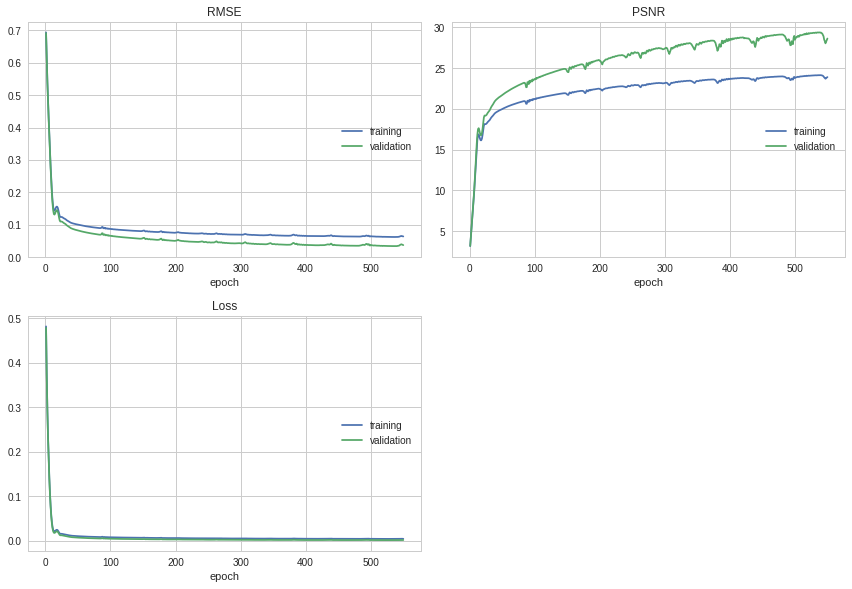

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

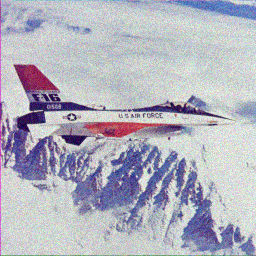

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

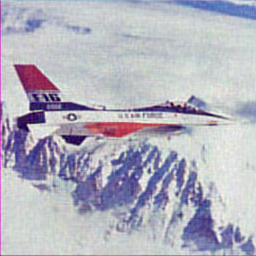

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

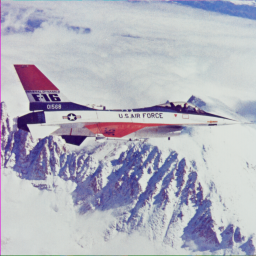

<IPython.core.display.Javascript object>

28.593323230743408


In [19]:
tracker_1D = Tracker()
net = Generator1D()
opt_kwargs = {'lr': 1e-3}
noise_size = 256*3
sigma = 0.1
epochs = 550
image,psnr = example_main_loop(net, torch.optim.Adam, opt_kwargs,
                          torch.nn.MSELoss(), noise_size,
                          images[1], sigma, epochs,
                          tracker=tracker_1D)

print(psnr)

In [0]:
num_params(net)

6468835

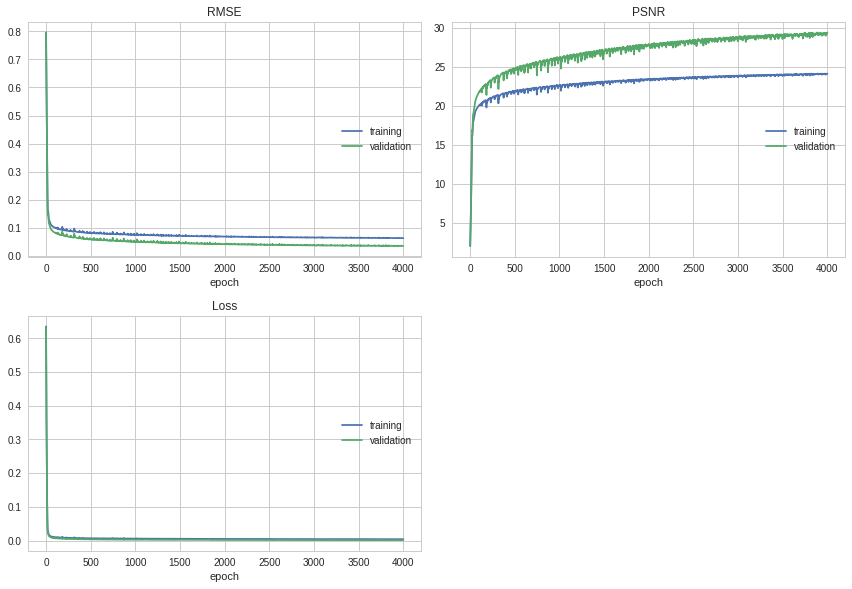

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

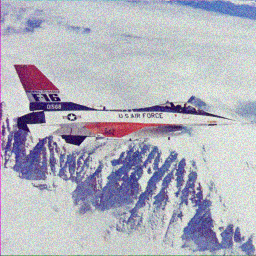

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

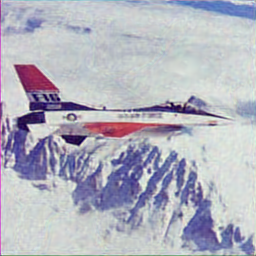

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

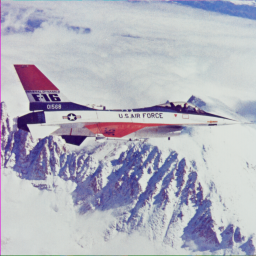

<IPython.core.display.Javascript object>

[29.26058053970337]


In [20]:
psnr_values=[]
for i in range (0,1):
  tracker_2D = Tracker()
  net = Generator2D()
  opt_kwargs = {'lr': 1e-3}
  noise_size = (32, 256, 256)
  sigma = 0.1
  epochs = 4000
  image,psnr = example_main_loop(net, torch.optim.Adam, opt_kwargs,
                            torch.nn.MSELoss(), noise_size,
                            images[1], sigma, epochs,
                            tracker=tracker_2D)
  psnr_values.append(psnr)
  
print(psnr_values)

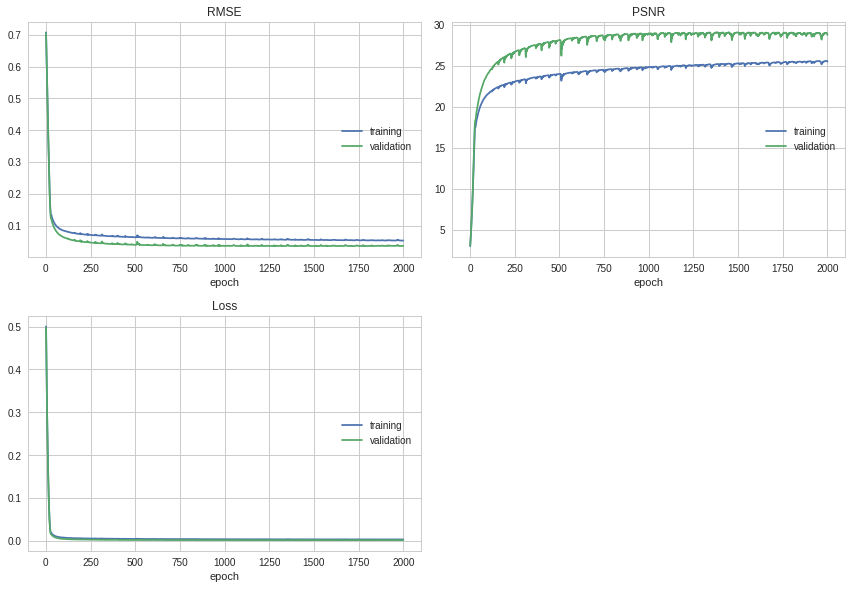

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

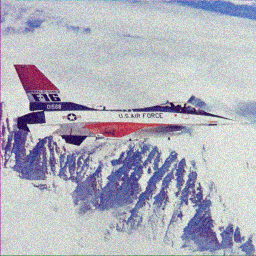

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

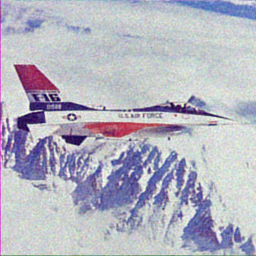

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

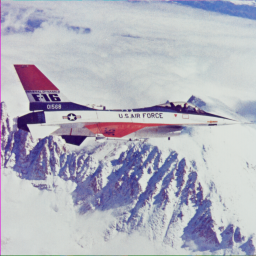

<IPython.core.display.Javascript object>

28.139007091522217


In [0]:
#2ds with residual links

tracker_2DS = Tracker()
net = Generator2DS()
opt_kwargs = {'lr': 1e-3}
noise_size = (32, 256, 256)
sigma = 0.1
epochs = 2000
image,psnr = example_main_loop(net, torch.optim.Adam, opt_kwargs,
                          torch.nn.MSELoss(), noise_size,
                          images[1], sigma, epochs,
                          tracker=tracker_2DS)
print(psnr)

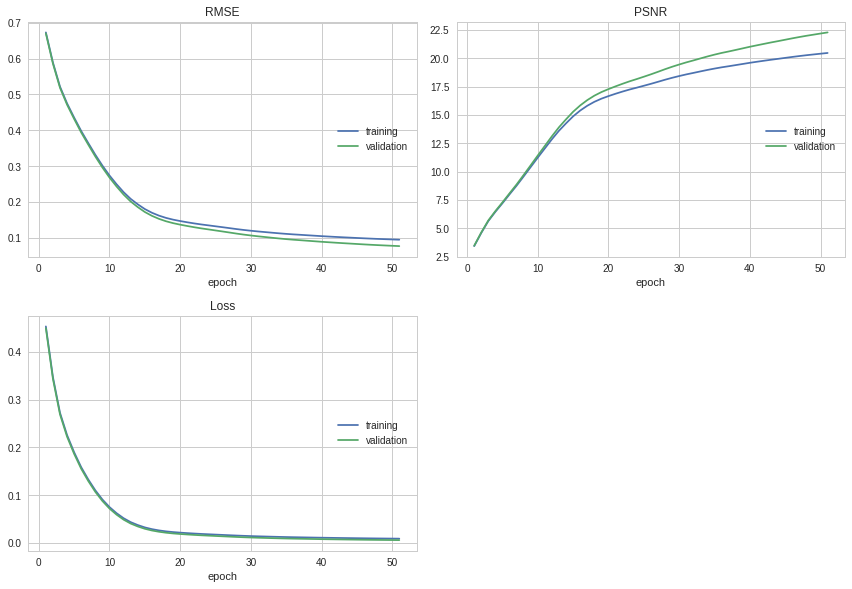

KeyboardInterrupt: ignored

In [30]:
# Trying to overfit 2DS with 10,000 epochs

tracker_2DS = Tracker()
net = Generator2DS()
opt_kwargs = {'lr': 1e-3}
noise_size = (32, 256, 256)
sigma = 0.1
epochs = 10_000
image = example_main_loop(net, torch.optim.Adam, opt_kwargs,
                          torch.nn.MSELoss(), noise_size,
                          images[4], sigma, epochs,
                          tracker=tracker_2DS)

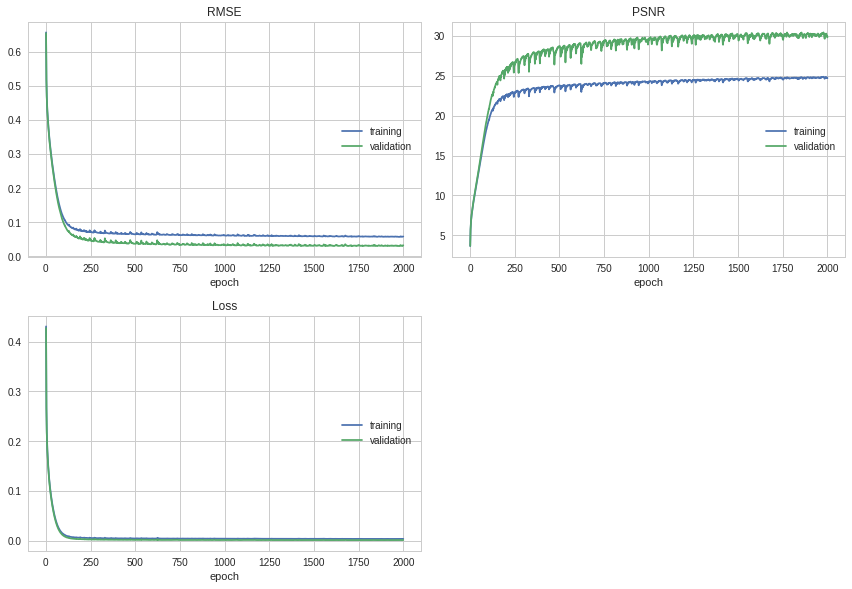

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

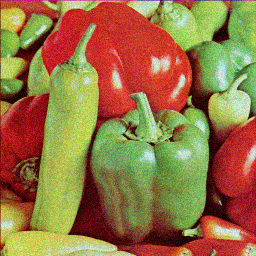

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

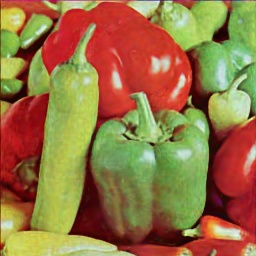

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

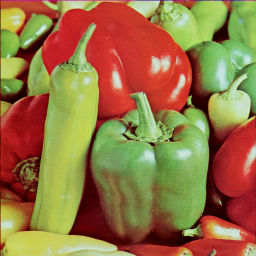

<IPython.core.display.Javascript object>

In [36]:
# 2ds - half the amount of filters

tracker_2DS = Tracker()
net = Generator2DS()
opt_kwargs = {'lr': 1e-3}
noise_size = (32, 256, 256)
sigma = 0.1
epochs = 2000
image = example_main_loop(net, torch.optim.Adam, opt_kwargs,
                          torch.nn.MSELoss(), noise_size,
                          images[4], sigma, epochs,
                          tracker=tracker_2DS)

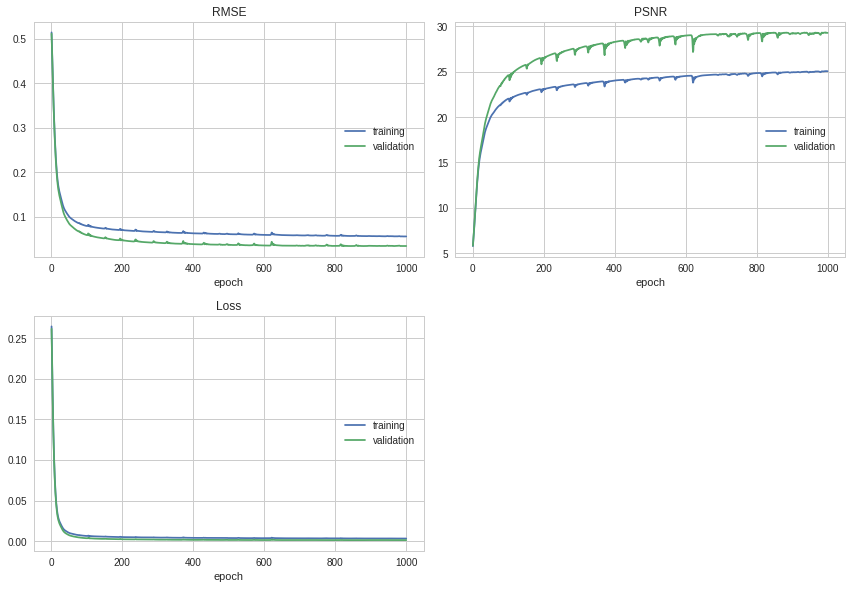

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

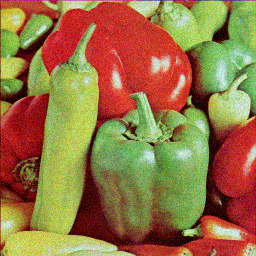

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

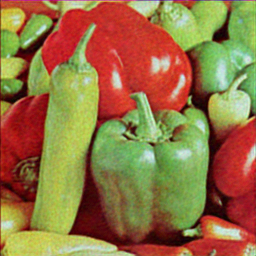

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

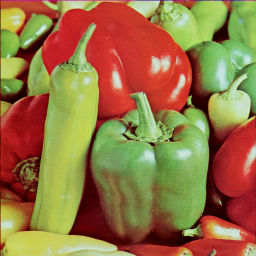

<IPython.core.display.Javascript object>

29.121077060699463


In [33]:
# 2DC - skip connections "concat style"
tracker_2DC = Tracker()
net = Generator2DC()
opt_kwargs = {'lr': 1e-3}
noise_size = (32, 256, 256)
sigma = 0.1
epochs = 1000
image,psnr = example_main_loop(net, torch.optim.Adam, opt_kwargs,
                          torch.nn.MSELoss(), noise_size,
                          images[4], sigma, epochs,
                          tracker=tracker_2DC)

print(psnr)

In [34]:
# 2ds PSNR mean

psnr_values = []
for image in images:
  net = Generator2DS()
  opt_kwargs = {'lr': 1e-3}
  noise_size = (32, 256, 256)
  sigma = 0.1
  epochs = 1500
  _, image_psnr = example_main_loop(net, torch.optim.Adam, opt_kwargs,
                            torch.nn.MSELoss(), noise_size,
                            image, sigma, epochs, output_rate=2000)
  psnr_values.append(image_psnr)

  
print(psnr_values)
print(np.mean(psnr_values))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


{'rmse': 0.6658392410708719, 'psnr': 3.532612267746072, 'loss': 0.4433418810367584, 'val_rmse': 0.66359776, 'val_psnr': 3.5619018, 'val_loss': 0.44036200642585754}


KeyboardInterrupt: ignored

In [0]:
# edited from https://github.com/e-lab/pytorch-toolbox/blob/master/profiler/profile.py
def count_conv2d(m, x, y):
  x = x[0]

  cin = m.in_channels // m.groups
  cout = m.out_channels // m.groups
  kh, kw = m.kernel_size
  batch_size = x.size()[0]

  # ops per output element
  kernel_mul = kh * kw * cin
  kernel_add = kh * kw * cin - 1
  bias_ops = 1 if m.bias is not None else 0
  
  add = kernel_add + bias_ops

  # total ops
  num_out_elements = y.numel()
  total_add = num_out_elements * add
  total_mul = num_out_elements * kernel_mul

  # incase same conv is used multiple times
  m.total_add += torch.Tensor([int(total_add)])
  m.total_mul += torch.Tensor([int(total_mul)])

def count_bn2d(m, x, y):
  x = x[0]

  nelements = x.numel()
  total_sub = nelements
  total_div = nelements
  total_ops = total_sub + total_div

  m.total_ops += torch.Tensor([int(total_ops)])

def count_relu(m, x, y):
  x = x[0]

  nelements = x.numel()
  total_ops = nelements

  m.total_ops += torch.Tensor([int(total_ops)])

def count_maxpool(m, x, y):
  kernel_ops = torch.prod(torch.Tensor([m.kernel_size])) - 1
  num_elements = y.numel()
  total_ops = kernel_ops * num_elements

  m.total_ops += torch.Tensor([int(total_ops)])

def count_avgpool(m, x, y):
  total_add = torch.prod(torch.Tensor([m.kernel_size])) - 1
  total_div = 1
  kernel_ops = total_add + total_div
  num_elements = y.numel()
  total_ops = kernel_ops * num_elements

  m.total_ops += torch.Tensor([int(total_ops)])

def count_linear(m, x, y):
  # per output element
  num_elements = y.numel()
  
  total_add = m.in_features * num_elements
  total_mul = (m.in_features - 1) * num_elements

  m.total_add = torch.Tensor([int(total_add)])
  m.total_mul = torch.Tensor([int(total_mul)])

def profile(model, input_size, custom_ops = {}):

  model.eval()

  def add_hooks(m):
      if len(list(m.children())) > 0: return
      m.register_buffer('total_params', torch.zeros(1))
      m.register_buffer('total_add', torch.zeros(1))
      m.register_buffer('total_mul', torch.zeros(1))

      for p in m.parameters():
          m.total_params += torch.Tensor([p.numel()])

      if isinstance(m, nn.Conv2d):
          m.register_forward_hook(count_conv2d)
#       elif isinstance(m, nn.BatchNorm2d):
#           m.register_forward_hook(count_bn2d)
#       elif isinstance(m, nn.ReLU):
#           m.register_forward_hook(count_relu)
#       elif isinstance(m, (nn.MaxPool1d, nn.MaxPool2d, nn.MaxPool3d)):
#           m.register_forward_hook(count_maxpool)
#       elif isinstance(m, (nn.AvgPool1d, nn.AvgPool2d, nn.AvgPool3d)):
#           m.register_forward_hook(count_avgpool)
      elif isinstance(m, nn.Linear):
          m.register_forward_hook(count_linear)
      elif isinstance(m, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
          pass
      else:
          print("Not implemented for ", m)

  model.apply(add_hooks)

  x = torch.zeros(input_size)
  model(x)

  total_params = 0
  total_add = 0
  total_mul = 0
  for m in model.modules():
      if len(list(m.children())) > 0: continue
      total_add += m.total_add
      total_mul += m.total_mul
      total_params += m.total_params
      print(total_add, total_mul)
      
  total_params = total_params

  return total_add, total_mul, total_params

In [0]:
net = Generator2DC()
add, mul, ops = profile(net, (32, 256, 256))
print(f'{int(add)}, {int(mul)}, {int(ops)}')

Not implemented for  LeakyReLU(negative_slope=0.01)
Not implemented for  BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Not implemented for  LeakyReLU(negative_slope=0.01)
Not implemented for  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Not implemented for  ReLU(inplace)
Not implemented for  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Not implemented for  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Not implemented for  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Not implemented for  ReLU(inplace)
Not implemented for  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Not implemented for  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Not implemented for  BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Not implemente

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor([0.]) tensor([0.])
tensor([4.1943e+08]) tensor([4.1943e+08])
tensor([4.1943e+08]) tensor([4.1943e+08])
tensor([4.9467e+08]) tensor([4.9493e+08])
tensor([4.9467e+08]) tensor([4.9493e+08])
tensor([4.9467e+08]) tensor([4.9493e+08])
tensor([6.4540e+08]) tensor([6.4592e+08])
tensor([6.4540e+08]) tensor([6.4592e+08])
tensor([6.5379e+08]) tensor([6.5431e+08])
tensor([6.5379e+08]) tensor([6.5431e+08])
tensor([7.2915e+08]) tensor([7.2981e+08])
tensor([7.2915e+08]) tensor([7.2981e+08])
tensor([7.2915e+08]) tensor([7.2981e+08])
tensor([8.8002e+08]) tensor([8.8080e+08])
tensor([8.8002e+08]) tensor([8.8080e+08])
tensor([8.8841e+08]) tensor([8.8919e+08])
tensor([8.8841e+08]) tensor([8.8919e+08])
tensor([9.6384e+08]) tensor([9.6469e+08])
tensor([9.6384e+08]) tensor([9.6469e+08])
tensor([9.6384e+08]) tensor([9.6469e+08])
tensor([1.1148e+09]) tensor([1.1157e+09])
tensor([1.1148e+09]) tensor([1.1157e+09])
tensor([1.1232e+09]) tensor([1.1241e+09])
tensor([1.1232e+09]) tensor([1.1241e+09])
tensor([